# 236756 - Machine Learning - Exercise 3
## Ron Sailer - 313341596
## Adam Erdreich - 302325709

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from itertools import combinations

from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, scale, FunctionTransformer
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 100) # to display all columns at all time
pd.options.mode.chained_assignment = None # to ignore false-positive warnings about chained assignments


In [2]:
data = pd.read_csv('ElectionsData.csv',header=0)
test = pd.read_csv('original/orig_test.csv', header=0)
train = pd.read_csv('original/orig_train.csv', header=0)
validation = pd.read_csv('original/orig_validation.csv',header=0)
# merged train and test
train_test = pd.concat([train, test], keys=['train', 'test'])

for df in [train,test,validation,train_test]:
    df.drop([x for x in df.columns.values if 'Unnamed' in x],axis=1,inplace=True)

In [3]:
train_test

Vote  Occupation_Satisfaction  \
train 0       Pinks                      2.0   
      1      Whites                      6.0   
      2     Yellows                      7.0   
      3     Yellows                     10.0   
      4     Yellows                      1.0   
      5     Oranges                      3.0   
      6       Blues                      7.0   
      7     Yellows                      9.0   
      8       Blues                      6.0   
      9     Yellows                     10.0   
      10     Greens                      7.0   
      11    Yellows                      5.0   
      12    Yellows                      9.0   
      13     Whites                      3.0   
      14    Oranges                      1.0   
      15      Greys                      2.0   
      16      Blues                      6.0   
      17       Reds                      1.0   
      18       Reds                     10.0   
      19       Reds                     10.0   
      20       Reds                      3.0   
      21      Pinks                      7.0   
      22      Greys                      3.0   
      23      Blues                      4.0   
      24    Oranges                      4.0   
      25      Blues                      8.0   
      26      Greys                      6.0   
      27      Pinks                      7.0   
      28    Yellows                      3.0   
      29     Whites                      6.0   
...             ...                      ...   
test  1970   Greens                      3.0   
      1971  Yellows                      4.0   
      1972  Yellows                      7.0   
      1973    Greys                     10.0   
      1974   Whites                      1.0   
      1975  Yellows                      2.0   
      1976    Blues                     10.0   
      1977  Yellows                      3.0   
      1978  Oranges                      9.0   
      1979     Reds                      1.0   
      1980  Yellows                      2.0   
      1981    Pinks                      3.0   
      1982  Oranges                      6.0   
      1983  Oranges                      5.0   
      1984   Whites                      5.0   
      1985  Yellows                      8.0   
      1986     Reds                      6.0   
      1987  Yellows                      7.0   
      1988  Yellows                      5.0   
      1989   Greens                      7.0   
      1990  Yellows                     10.0   
      1991  Yellows                     10.0   
      1992   Whites                      7.0   
      1993    Blues                      2.0   
      1994  Yellows                     10.0   
      1995    Greys                     10.0   
      1996   Browns                      8.0   
      1997  Oranges                      2.0   
      1998   Greens                      7.0   
      1999  Yellows                      5.0   

            Avg_monthly_expense_when_under_age_21  AVG_lottary_expanses  \
train 0                                595.173397         193266.754955   
      1                                576.314893         167698.043988   
      2                                117.576238          17404.440753   
      3                                448.796282          77583.844786   
      4                                568.890720          91718.020954   
      5                                263.632787          67266.885845   
      6                                447.731347          92158.684478   
      7                                913.240667         120919.120670   
      8                                147.743382          29556.103159   
      9                                682.927171          88581.249318   
      10                               515.716921         171298.733021   
      11                               950.001016         177358.415045   
      12                               914.946453         12725

## Code from the last exercise for data preparation

Some points to note:
* Train and Test are prepared as one (train_test) and then split with the original split of train and test.

### These are just some helper functions

You can skip these..

In [4]:
def count_categories(attr):
    return len(data[attr].astype('category').cat.categories)

obj_attr = [(col, count_categories(col))  for col in data if data[col].dtype==np.object]
obj_attr_names = map(lambda x: x[0], obj_attr)

num_attr = [col  for col in data if data[col].dtype==np.float64]

for attr, cnt in obj_attr:
    for df in [train,test,train_test]:
        data[attr] = data[attr].astype('category')

In [5]:
def get_nan_per_row_counter(df):
    return Counter(df.isnull().sum(axis=1).tolist())

def plot_pie_nan_per_row(df):
    counter = get_nan_per_row_counter(df)
    labels, histogram = zip(*counter.most_common())
    fig1, ax1 = plt.subplots()
    ax1.pie(histogram, labels=labels,
            colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral'],
            explode = [0.1] * len(histogram),
            autopct = lambda(p): '{:.0f}  ({:.2f}%)'.format(p * sum(histogram) / 100, p)
           )
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

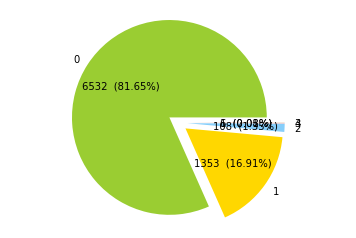

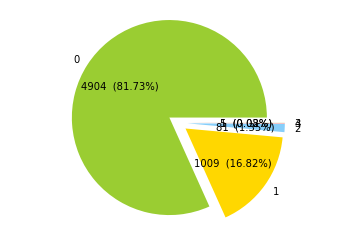

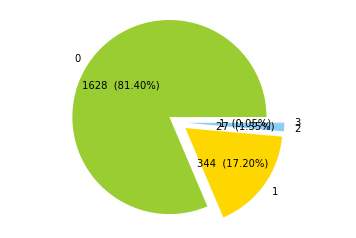

In [6]:
plot_pie_nan_per_row(train_test)
plot_pie_nan_per_row(train)
plot_pie_nan_per_row(test)

# Imputation

### Class-Restricted imputation

(Of train and test only)

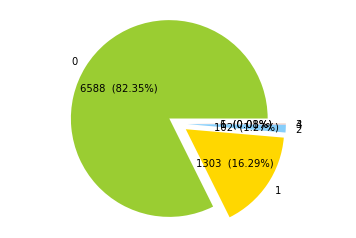

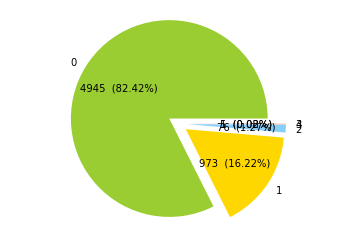

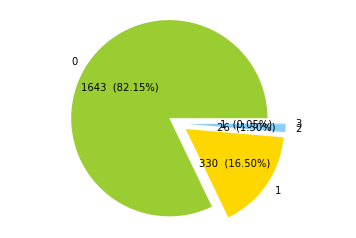

In [7]:
for df in [train_test,train,test]:
    vote_to_features = df[['Vote','Looking_at_poles_results','Will_vote_only_large_party','Financial_agenda_matters']].dropna().drop_duplicates().set_index(['Vote']).to_dict('index')
    for party, feature_dict in vote_to_features.iteritems():
        df[df.Vote==party] = df[df.Vote==party].fillna(feature_dict)
    plot_pie_nan_per_row(df)

## Pearson's correlation

Take the most correlated features and impute using one another.

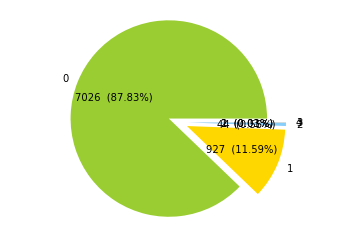

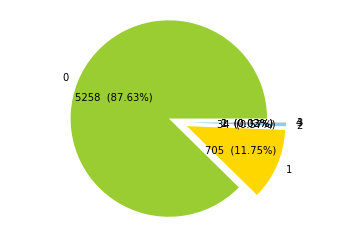

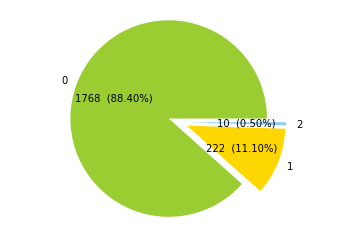

In [8]:
def get_most_correlated(corr_mat, col, thresh):
    res = pearson[col].reindex(pearson[col].abs().sort_values(ascending=False).index)
    res = res[res.index != col]
    return res[res >= thresh]

pearson_coeff_thresh = 0.95

for df in [train_test,train,test]:
    pearson = df.corr(method='pearson')

    # a dict mapping each feature with its 3 most-correlated features, only if the corr with the best of them is >=0.9 (in abs value)
    sorted_pearson_per_col = {col: \
                              get_most_correlated(pearson, col, pearson_coeff_thresh) for col in pearson\
                             if get_most_correlated(pearson, col, pearson_coeff_thresh).any()}
    
    df_copy = df.copy()
    
    for col, top_corr_cols in sorted_pearson_per_col.iteritems():
        for corr_col in top_corr_cols.index:
            ratio = (df_copy[col] / df_copy[corr_col]).mean()
            cols = df_copy[[col, corr_col]]
            cols[corr_col] = cols[corr_col].map(lambda x: x*ratio)
            df[col].fillna(cols[corr_col], inplace=True)
    
    plot_pie_nan_per_row(df)

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def __test_regressor_accuracy(df, forest, attr='Vote'):
    score = cross_val_score(estimator, X_missing, y_missing).mean()
    print("Score after imputation of the missing values = %.2f" % score)
    


def _train_regressor_on_feature(df, attr, verbose):
    train_data_X = df.drop([attr],axis=1).values
    train_data_Y = df[attr].values

    forest = RandomForestRegressor(n_estimators = 100)

    return forest.fit(train_data_X, train_data_Y)


def _prepare_for_regression(df, attr, verbose):
    df_tmp = df.copy()
    #convert all categorical features to one-hot vectors because otherwise we are stuck with strings
    for a,c in [x for x in obj_attr if x[0] != attr]:
        df_tmp = pd.concat([df_tmp,pd.get_dummies(df_tmp[a],prefix=a,dummy_na=True)], axis=1)
        df_tmp = df_tmp.drop([a],axis=1)
    #drop all rows with nan
    df_tmp_noNaN = df_tmp.dropna()
    #get the rows to impute
    to_regress = df_tmp[pd.isnull(df_tmp[attr])].drop([attr],axis=1)
    #train a regressor to impute these rows
    regressor = _train_regressor_on_feature(df_tmp_noNaN,attr,verbose)
    return to_regress, regressor


def impute_numerical(df, verbose=False):
    to_regress = None
    results = {}
    
    #go over all numerical attributes
    for attr in num_attr:
        print attr
        to_keep = [df.loc[k].isnull().sum() < 2 for k in df.index.values]
        df_no_multiple_nan = df.loc[to_keep]
        #get regressor for that problem
        to_regress, regressor = _prepare_for_regression(df_no_multiple_nan, attr, verbose)
        #if there are things to impute
        if to_regress.shape[0] > 0:
            #get a list of the regressor results
            results[attr] = list(regressor.predict(to_regress))
            if verbose:
                print results[attr]
    #fill in the missing values
    print "FINISHED THIS"
    for attr, res in results.iteritems():
        j = 0
        print attr, res
        for i in df.index.values:
            if np.isnan(df[attr][i]) == False or df.loc[i].isnull().sum() > 1:
                continue
            print i,j,res[j],"before:",df[attr][i]
            df.set_value(i,attr,res[j])
            print "after:",df[attr][i]
            j += 1
    return df

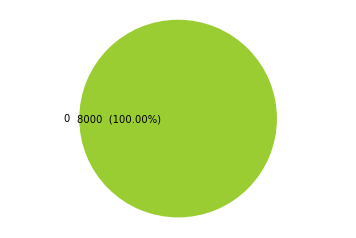

In [37]:
train_test = impute_numerical(train_test,True)
plot_pie_nan_per_row(train_test)

## Impute the rest

We now tried to find a method to properly impute all other missing data, while taking into account mostly the preservation of relations between features, to best fit our mission of applying machine-learning on the data.

we considered EM as taught in the lectures, but found the assumption of Multivariate-Gaussian distribution to mostly incorrect when it comes to our data.

after looking for a while, and considering different methods, we have decided to use SoftImpute, based on this paper: http://web.stanford.edu/~hastie/Papers/mazumder10a.pdf.

"SoftImpute" also conviniently has an open-source implementation in Python.

[SoftImpute] Max Singular Value of X_init = 84375251.424460
[SoftImpute] Iter 1: observed MAE=2514.767421 rank=4
[SoftImpute] Iter 2: observed MAE=2516.232754 rank=4
[SoftImpute] Iter 3: observed MAE=2516.738204 rank=4
[SoftImpute] Iter 4: observed MAE=2516.959014 rank=4
[SoftImpute] Iter 5: observed MAE=2517.045137 rank=4
[SoftImpute] Iter 6: observed MAE=2517.081977 rank=4
[SoftImpute] Iter 7: observed MAE=2517.098922 rank=4
[SoftImpute] Iter 8: observed MAE=2517.107101 rank=4
[SoftImpute] Iter 9: observed MAE=2517.111167 rank=4
[SoftImpute] Iter 10: observed MAE=2517.113223 rank=4
[SoftImpute] Iter 11: observed MAE=2517.114272 rank=4
[SoftImpute] Stopped after iteration 11 for lambda=1687505.028489


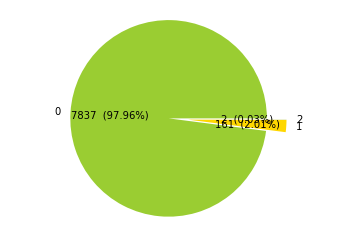

[SoftImpute] Max Singular Value of X_init = 73224175.433837
[SoftImpute] Iter 1: observed MAE=2526.688069 rank=4
[SoftImpute] Iter 2: observed MAE=2534.931212 rank=4
[SoftImpute] Iter 3: observed MAE=2538.045856 rank=4
[SoftImpute] Iter 4: observed MAE=2539.153555 rank=4
[SoftImpute] Iter 5: observed MAE=2539.543464 rank=4
[SoftImpute] Iter 6: observed MAE=2539.686565 rank=4
[SoftImpute] Iter 7: observed MAE=2539.746246 rank=4
[SoftImpute] Iter 8: observed MAE=2539.772432 rank=4
[SoftImpute] Iter 9: observed MAE=2539.785215 rank=4
[SoftImpute] Iter 10: observed MAE=2539.791354 rank=4
[SoftImpute] Iter 11: observed MAE=2539.794365 rank=4
[SoftImpute] Stopped after iteration 11 for lambda=1464483.508677


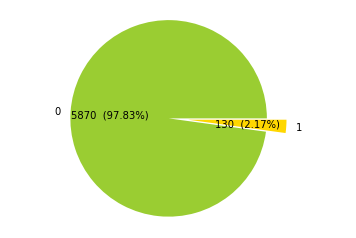

[SoftImpute] Max Singular Value of X_init = 41914300.712489
[SoftImpute] Iter 1: observed MAE=2482.784733 rank=4
[SoftImpute] Iter 2: observed MAE=2484.641253 rank=4
[SoftImpute] Iter 3: observed MAE=2485.544382 rank=4
[SoftImpute] Iter 4: observed MAE=2486.028059 rank=4
[SoftImpute] Iter 5: observed MAE=2486.245928 rank=4
[SoftImpute] Iter 6: observed MAE=2486.351481 rank=4
[SoftImpute] Iter 7: observed MAE=2486.406590 rank=4
[SoftImpute] Iter 8: observed MAE=2486.438527 rank=4
[SoftImpute] Iter 9: observed MAE=2486.456428 rank=4
[SoftImpute] Iter 10: observed MAE=2486.467396 rank=4
[SoftImpute] Iter 11: observed MAE=2486.474044 rank=4
[SoftImpute] Iter 12: observed MAE=2486.477848 rank=4
[SoftImpute] Stopped after iteration 12 for lambda=838286.014250


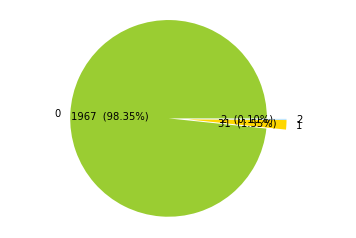

In [11]:
from fancyimpute import SoftImpute

for df in [train_test,train,test]:
    data_no_cat = df.drop(obj_attr_names, axis=1)
    completed = SoftImpute().complete(data_no_cat)
    df[data_no_cat.columns] = completed
    plot_pie_nan_per_row(df)

## Impute categorical features

In [12]:
def __test_accuracy(df, attr='Vote',num_of_iterations=5):
    train_data_X = df.drop([attr],axis=1).values
    train_data_Y = df[attr].values
    avg_accuracy = 0
    for i in range(num_of_iterations):
        # Prepare train and test data using cross validation
        X_train, X_test, Y_train, Y_test = train_test_split(train_data_X,train_data_Y)

        forest = RandomForestClassifier(n_estimators = 10)
        clf = forest.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        avg_accuracy += metrics.accuracy_score(Y_test, Y_pred)
    print attr+" accuracy:", avg_accuracy/num_of_iterations
    return avg_accuracy/num_of_iterations

def _train_classifier_on_feature(df, attr, verbose):
    train_data_X = df.drop([attr],axis=1).values
    train_data_Y = df[attr].values
    
    if verbose:
        __test_accuracy(df,attr)
        
    forest = RandomForestClassifier(n_estimators = 10)
    return forest.fit(train_data_X, train_data_Y)


def _prepare_for_impute(df, attr, count, verbose):
    df_tmp = df.copy()
    for a,c in [(x,y) for x,y in obj_attr if x != attr]:
        df_tmp = pd.concat([df_tmp,pd.get_dummies(df_tmp[a],prefix=a,dummy_na=True)], axis=1)
        df_tmp = df_tmp.drop([a],axis=1)
    #drop all rows with nan in certain column
    df_tmp_noNaN = df_tmp.dropna(subset=[attr],axis=0)
    to_classify = df_tmp[pd.isnull(df_tmp[attr])].drop([attr],axis=1)
    clf = _train_classifier_on_feature(df_tmp_noNaN,attr,verbose)
    return to_classify, clf


def impute_categories(df, verbose=False):
    to_classify = None
    results = {}

    for attr, count in obj_attr:
        to_classify, clf = _prepare_for_impute(df, attr, count, verbose)
        if to_classify.shape[0] > 0:
            results[attr] = list(clf.predict(to_classify))
            if verbose:
                print results[attr]
    for attr, res in results.iteritems():
        j = 0
        for i in df.index.values:
            if df[attr][i] is not np.nan:
                continue
            df[attr][i] = results[attr][j]
            j += 1
    return df

In [13]:
#you can replace the first line with the commented line to see a verbose version
#train_test = impute_categories(train_test,verbose=True)
train_test = impute_categories(train_test)
train = impute_categories(train)
test = impute_categories(test)

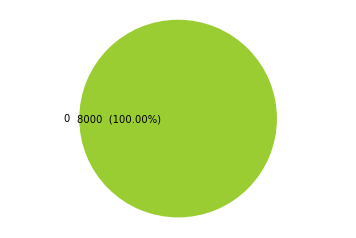

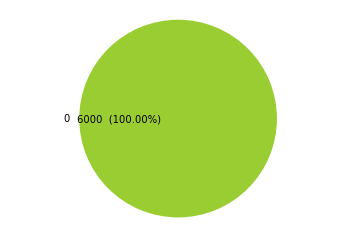

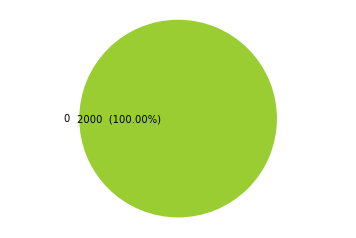

In [14]:
for df in [train_test,train,test]:
    plot_pie_nan_per_row(df)

In [15]:
train_test

Vote  Occupation_Satisfaction  \
train 0       Pinks                      2.0   
      1      Whites                      6.0   
      2     Yellows                      7.0   
      3     Yellows                     10.0   
      4     Yellows                      1.0   
      5     Oranges                      3.0   
      6       Blues                      7.0   
      7     Yellows                      9.0   
      8       Blues                      6.0   
      9     Yellows                     10.0   
      10     Greens                      7.0   
      11    Yellows                      5.0   
      12    Yellows                      9.0   
      13     Whites                      3.0   
      14    Oranges                      1.0   
      15      Greys                      2.0   
      16      Blues                      6.0   
      17       Reds                      1.0   
      18       Reds                     10.0   
      19       Reds                     10.0   
      20       Reds                      3.0   
      21      Pinks                      7.0   
      22      Greys                      3.0   
      23      Blues                      4.0   
      24    Oranges                      4.0   
      25      Blues                      8.0   
      26      Greys                      6.0   
      27      Pinks                      7.0   
      28    Yellows                      3.0   
      29     Whites                      6.0   
...             ...                      ...   
test  1970   Greens                      3.0   
      1971  Yellows                      4.0   
      1972  Yellows                      7.0   
      1973    Greys                     10.0   
      1974   Whites                      1.0   
      1975  Yellows                      2.0   
      1976    Blues                     10.0   
      1977  Yellows                      3.0   
      1978  Oranges                      9.0   
      1979     Reds                      1.0   
      1980  Yellows                      2.0   
      1981    Pinks                      3.0   
      1982  Oranges                      6.0   
      1983  Oranges                      5.0   
      1984   Whites                      5.0   
      1985  Yellows                      8.0   
      1986     Reds                      6.0   
      1987  Yellows                      7.0   
      1988  Yellows                      5.0   
      1989   Greens                      7.0   
      1990  Yellows                     10.0   
      1991  Yellows                     10.0   
      1992   Whites                      7.0   
      1993    Blues                      2.0   
      1994  Yellows                     10.0   
      1995    Greys                     10.0   
      1996   Browns                      8.0   
      1997  Oranges                      2.0   
      1998   Greens                      7.0   
      1999  Yellows                      5.0   

            Avg_monthly_expense_when_under_age_21  AVG_lottary_expanses  \
train 0                                595.173397         193266.754955   
      1                                576.314893         167698.043988   
      2                                117.576238          17404.440753   
      3                                448.796282          77583.844786   
      4                                568.890720          91718.020954   
      5                                263.632787          67266.885845   
      6                                447.731347          92158.684478   
      7                                913.240667         120919.120670   
      8                                147.743382          29556.103159   
      9                                682.927171          88581.249318   
      10                               515.716921         171298.733021   
      11                               950.001016         177358.415045   
      12                               914.946453         12725

# DONE WITH IMPUTATION!

Our next steps are to remove outliers, normalize the data, convert categorical values to one-hot vectors and select the feature subset.

## Function to calculate the prediction accuracy

In [27]:
def test_vote_prediction_accuracy(df,num_of_iterations=20,random_state=1):
    avg_acc_tree = 0
    #avg_svm = 0

    train_data_X = df.drop(['Vote'],axis=1).values
    train_data_Y = df['Vote'].values

    for i in range(num_of_iterations):

        # Prepare train and test data using cross validation
        X_train, X_test, Y_train, Y_test = train_test_split(train_data_X,train_data_Y,random_state=random_state)

        # Example usage 1
        forest = RandomForestClassifier(n_estimators = 60)
        clf = forest.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        avg_acc_tree += metrics.accuracy_score(Y_test, Y_pred)

    return avg_acc_tree/num_of_iterations


## Convert categories to one-hot vectors

In [17]:
def numerize(df):
    for attr in ['Financial_agenda_matters','Will_vote_only_large_party']:
        df[attr] = df[attr].map({'No':0, 'Yes':1}).astype(float)
        
    # Handle categorical columns and add one-hot vectors
    for attr in ['Most_Important_Issue']:
        df = pd.concat([df, pd.get_dummies(df[attr],prefix=attr)], axis=1)
        df = df.drop([attr],axis=1)
        
    return df

In [18]:
train_test = numerize(train_test)
train = numerize(train)
test = numerize(test)

## Type Modification and Feature Selection

In [19]:
def leave_only_important_features(df):
    features = df.columns.values
    important_features = ['Vote','Yearly_ExpensesK','Yearly_IncomeK','Overall_happiness_score',
    'Avg_Residancy_Altitude']
    important_features += [x for x in features if 'Most_Important_Issue' in x]
    important_features += [x for x in features if 'Will_vote_only_large_party' in x]
    important_features += [x for x in features if 'Financial_agenda_matters' in x]
    return df[important_features]

In [20]:
train_test = leave_only_important_features(train_test)
train = leave_only_important_features(train)
test = leave_only_important_features(test)

## Outlier Detection

This function tries to find the best outlier ratio and returns that. It will binarically search for a good outlier ratio (0.2, 0.1, 0.05, 0.075, 0.625 etc..). This ratio isn't guaranteed to be the best, it might just be a local maxima. However, in most cases, the best prediction accuracy is found using the entire dataset and so, if the outlier ratio is less than epsilon, we won't remove any outliers at all.

Because in real life we could be working with huge datasets and setting arbitrary outlier limits isn't the best idea, we think it is better to let the computer decide.

In [29]:
def find_outliers(df, outliers_fraction=0.2,epsilon = 0.005):
    
    outliers_fraction=max(outliers_fraction,epsilon)
    
    delta = outliers_fraction
    df2 = df.copy().drop(['Vote'],axis=1)
          
    #check accuracy before removing outliers
    accuracy_before = test_vote_prediction_accuracy(df)
    print "accuracy_before:", accuracy_before
    
    best_df = df
    best_outlier_fraction = outliers_fraction
    best_accuracy = accuracy_before

    while delta >= epsilon:
        delta = delta/2
        print "best outlier fraction:",best_outlier_fraction
        print "current outlier fraction:",outliers_fraction
        
        clf = IsolationForest(n_estimators=100, contamination=outliers_fraction, n_jobs=-1)
        clf.fit(df2)
        y_pred = clf.predict(df2)

        outliers = np.where(y_pred==-1)[0]
        df_no_outliers = df.drop(df2.index[outliers])

        #check accuracy after removing outliers
        accuracy_after = test_vote_prediction_accuracy(df_no_outliers)
        print "accuracy_after:", accuracy_after

        if best_accuracy > accuracy_after:
            outliers_fraction -= delta
        else:
            best_outlier_fraction = outliers_fraction
            best_df = df_no_outliers
            outliers_fraction += delta
            best_accuracy = accuracy_after
    
    return best_df, outliers


#uncomment this to try it out!
train_test2, outliers2 = find_outliers(train_test)

accuracy_before: 0.8715
best outlier fraction: 0.2
current outlier fraction: 0.2
accuracy_after: 0.863125
best outlier fraction: 0.2
current outlier fraction: 0.1
accuracy_after: 0.859444444444
best outlier fraction: 0.2
current outlier fraction: 0.05
accuracy_after: 0.863684210526
best outlier fraction: 0.2
current outlier fraction: 0.025
accuracy_after: 0.872820512821
best outlier fraction: 0.025
current outlier fraction: 0.0375
accuracy_after: 0.866493506494
best outlier fraction: 0.025
current outlier fraction: 0.03125
accuracy_after: 0.877192982456


## Normalization

Because all remaining [numerical] features are distributed roughly geometrical we will use log-scale normalization.

We have tried fitting the data using sklearn.preprocessing.StandardScaler to use for SVMs but this assumes everything has a normal distribution, which is not the case. We fitted the scaler to the training data and then transformed the training and test data using the fitted scaler.

We did not see any improvement in performance and so we abandoned this idea.

In [33]:
train2 = train_test.loc['train']
test2 = train_test.loc['test']
train22 = train_test2.loc['train']
test22 = train_test2.loc['test']

In [34]:
print test_vote_prediction_accuracy(train_test)
print test_vote_prediction_accuracy(train_test2)
print test_vote_prediction_accuracy(train)
print test_vote_prediction_accuracy(test)
print test_vote_prediction_accuracy(train2)
print test_vote_prediction_accuracy(test2)
print test_vote_prediction_accuracy(train22)
print test_vote_prediction_accuracy(test22)

0.8715
0.877192982456
0.867333333333
0.836
0.872
0.83
0.861072902338
0.834710743802


## Saving the datasets

In [35]:
train_test2.to_csv('modified/afterpp_train_test2.csv')
train_test.to_csv('modified/afterpp_train_test.csv')
train2.to_csv('modified/afterpp_train2.csv')
test2.to_csv('modified/afterpp_test2.csv')

#this one is exactly the same as the original. No changes done..
#validation.to_csv('modified/afterpp_validation.csv')

In [36]:
train_test2

Vote  Yearly_ExpensesK  Yearly_IncomeK  \
train 0       Pinks        974.170331      970.413616   
      1      Whites        872.950080      946.750516   
      2     Yellows        444.080565      595.691149   
      3     Yellows        518.612885      630.670552   
      4     Yellows        483.667695      672.711812   
      5     Oranges        765.461155      825.025214   
      6       Blues        617.504348      634.798892   
      7     Yellows        397.219895      589.307392   
      8       Blues        600.150804      653.636335   
      9     Yellows        389.124579      576.922488   
      10     Greens        996.469533      997.206890   
      11    Yellows        560.078607      627.490533   
      12    Yellows        417.258122      585.188460   
      13     Whites        825.709662      936.394775   
      14    Oranges        458.910230      613.744912   
      15      Greys        648.330949      584.602644   
      16      Blues        418.882360      578.738899   
      17       Reds        590.675931      631.996314   
      18       Reds        360.299924      685.894045   
      19       Reds        577.068858      660.026916   
      20       Reds        589.494252      691.897285   
      21      Pinks        842.724294      602.571408   
      22      Greys        620.219811      577.180369   
      23      Blues        613.358755      658.654942   
      24    Oranges        762.486397      825.788513   
      25      Blues        555.716667      631.678519   
      26      Greys        461.061993      610.427609   
      27      Pinks        859.604933      800.196131   
      28    Yellows        434.741101      582.355480   
      30       Reds        605.005328      653.110196   
...             ...               ...             ...   
test  1969  Yellows        506.097054      633.717440   
      1970   Greens        809.020383      978.020194   
      1971  Yellows        384.313577      592.557671   
      1972  Yellows        376.197737      575.945981   
      1973    Greys        440.150727      578.531656   
      1974   Whites        854.570757      989.933272   
      1975  Yellows        440.806422      613.933783   
      1976    Blues        421.089074      606.889963   
      1977  Yellows        355.871762      558.286580   
      1978  Oranges        420.255585      570.065926   
      1979     Reds        399.522073      679.393801   
      1980  Yellows        378.904813      626.877060   
      1981    Pinks        502.953182      103.628287   
      1982  Oranges        426.279196      529.175634   
      1983  Oranges        815.674273      878.263976   
      1984   Whites        382.408591      523.368392   
      1985  Yellows        457.690795      569.990192   
      1986     Reds        385.745811      680.926413   
      1987  Yellows        495.942535      608.241625   
      1988  Yellows        471.075481      672.792171   
      1989   Greens        856.147437      898.291541   
      1990  Yellows        539.122507      645.846021   
      1991  Yellows        349.683215      578.882138   
      1992   Whites        405.032813      632.003695   
      1993    Blues        601.152728      648.390050   
      1994  Yellows        399.546819      543.849957   
      1995    Greys        493.198101      643.107471   
      1997  Oranges        398.672798      595.145339   
      1998   Greens        634.057629      529.778873   
      1999  Yellows        436.993626      550.296532   

            Overall_happiness_score  Avg_Residancy_Altitude  \
train 0                  980.243199              198.391132   
      1                  927.344946              192.104964   
      2                  629.598254               39.192079   
      3                  861.849478              149.598761   
      4                  709.757965              189.630240   
      5                  664.852995               87.877596   
      6                  668.549618    